In [56]:
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def audio_loader(path, max_length_in_seconds=1, pad_and_truncate=True):
    audio_tensor, sample_rate = torchaudio.load(path)
    max_length = sample_rate * max_length_in_seconds
    audio_size = audio_tensor.size()

    if pad_and_truncate:
        if audio_size[1] < max_length:
            difference = max_length - audio_size[1]
            padding = torch.zeros(audio_size[0], difference)
            padded_audio = torch.cat([audio_tensor, padding], 1)
            return padded_audio

        if audio_size[1] > max_length:
            random_idx = random.randint(0, audio_size[1] - max_length)
            return audio_tensor.narrow(1, random_idx, max_length)

    return audio_tensor


dataset = DatasetFolder(root='./dataset', loader=audio_loader, extensions='wav')
train_dataset, valid_dataset = train_test_split(dataset, test_size=0.2)


In [5]:
# ? dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=40,
    shuffle=False,
    num_workers=2,
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=10,
    shuffle=True,
    num_workers=2,
)


In [6]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()
  num_channels, num_frames = waveform.shape

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


Sample Rate: 44100
Shape: (1, 44100)
Dtype: torch.float32
 - Max:     0.535
 - Min:     -0.552
 - Mean:    -3.56e-06
 - Std dev: 0.0643
tensor([[-2.7130e-02,  8.4229e-03,  4.9591e-02,  ..., -9.1553e-05,
          9.1553e-05,  2.1362e-04]])


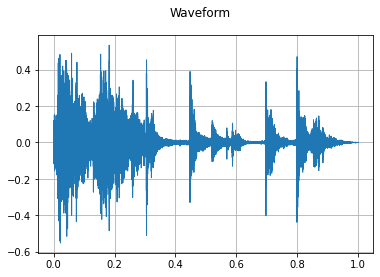

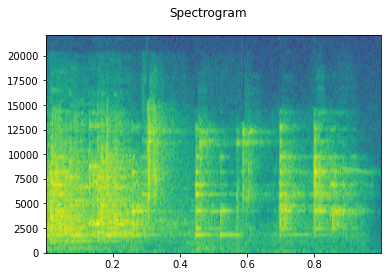

In [7]:
waveform = audio_loader('./dataset/5/147867.wav')
sample_rate = 44100

print("Sample Rate:", sample_rate)
print("Shape:", tuple(waveform.shape))
print("Dtype:", waveform.dtype)
print(f" - Max:     {waveform.max():.3g}")
print(f" - Min:     {waveform.min():.3g}")
print(f" - Mean:    {waveform.mean():.3g}")
print(f" - Std dev: {waveform.std():.3g}")
print(waveform)

plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)


tensor([[[4.5335e-06, 8.4615e-03, 1.7784e-03,  ..., 3.2555e-04,
          2.7974e-04, 1.4218e-04],
         [9.3556e-04, 9.9153e-02, 1.2004e-01,  ..., 5.6296e-03,
          1.1738e-03, 1.3993e-03],
         [1.3461e-02, 4.7552e-01, 1.9359e-01,  ..., 1.1361e-02,
          3.8280e-04, 1.6947e-03],
         ...,
         [7.1802e-05, 3.6659e-07, 6.6759e-08,  ..., 1.2033e-08,
          5.9234e-08, 2.3493e-08],
         [7.3552e-05, 2.8183e-07, 2.1825e-07,  ..., 6.4713e-08,
          2.3984e-08, 5.8357e-09],
         [7.5125e-05, 4.1560e-08, 1.3689e-06,  ..., 2.5468e-09,
          8.7557e-10, 1.9801e-09]]])


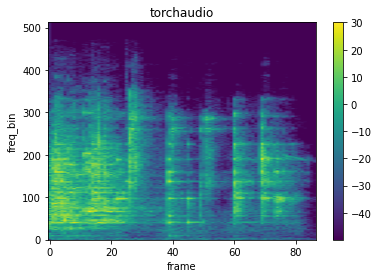

In [55]:
win_length = None
hop_length = 512


# define transformation
spectrogram = T.Spectrogram(
    n_fft=1024,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

spec = spectrogram(waveform)
print(spec)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    import librosa

    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

plot_spectrogram(spec[0], title='torchaudio')


In [8]:
class PrintLayer(nn.Module):
    def __init__(self, title=None):
        super().__init__()
        self.title = title

    def forward(self, x):
        print(self.title, x.shape)

        return x

class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.main = nn.Sequential(
            # PrintLayer('Start'),
            nn.Conv1d(1, 64, 80, 4, 2),
            # PrintLayer('Conv1'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, 80, 4, 2),
            # PrintLayer('Conv2'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, 80, 4, 2),
            # PrintLayer('Conv3'),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, 80, 4, 2),
            # PrintLayer('Conv4'),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 512, 40, 4, 2),
            # PrintLayer('Conv5'),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # PrintLayer('end'),
        )
        self.classifier = nn.Sequential(
            # PrintLayer('classifier'),
            nn.Linear(512 * 29, num_classes),
            # PrintLayer('linear'),
            nn.Softmax(dim=-1),
            # PrintLayer('softmax'),
        )

    def forward(self, tensor):
        batch_size = tensor.size(0)
        hidden = self.main(tensor)
        hidden = hidden.view(batch_size, -1)
        hidden = self.classifier(hidden)

        return hidden

audio_cnn = AudioCNN(len(dataset.classes)).to(device)
print(audio_cnn)


AudioCNN(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(80,), stride=(4,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv1d(64, 128, kernel_size=(80,), stride=(4,), padding=(2,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv1d(128, 256, kernel_size=(80,), stride=(4,), padding=(2,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv1d(256, 512, kernel_size=(80,), stride=(4,), padding=(2,))
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv1d(512, 512, kernel_size=(40,), stride=(4,), padding=(2,))
    (13): BatchNorm1d(512, eps=1e-05, 

In [9]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = optim.Adam(audio_cnn.parameters())


In [45]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        _, predicted = torch.max(output.data, 1)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    accuracy = 100 * correct / len(train_loader.dataset)

    return train_loss, accuracy

def valid(model, val_loader, criterion):
    model.eval()
    valid_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            _, predicted = torch.max(output.data, 1)

            valid_loss += loss.item()
            correct += (predicted == target).sum().item()

    valid_loss /= len(val_loader)
    accuracy = 100 * correct / len(val_loader.dataset)

    return valid_loss, accuracy


def predict(model, data):
    model.eval()

    with torch.no_grad():
        data = data.unsqueeze(1).to(device)
        output = model(data)
        accuracy, [predicted] = torch.max(output.data, 1)
        accuracy = 100 * accuracy.item()
        predicted = dataset.classes[predicted.item()]

        return predicted, accuracy


In [11]:
num_epochs = 100
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(audio_cnn, train_dataloader, optimizer, cross_entropy)
    valid_loss, valid_accuracy = valid(audio_cnn, valid_dataloader, cross_entropy)

    print(
        f'Epoch: {epoch+1}/{num_epochs}\t'
        f'Training (Loss, Accuracy): ({train_loss:.6f}, {train_accuracy:.2f}%)\t'
        f'Validation (Loss, Accuracy): ({valid_loss:.6f}, {valid_accuracy:.2f}%)\t'
    )
    
    train_losses.append(train_loss), train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss), valid_accuracies.append(valid_accuracy)


Epoch: 1/100	Training (Loss, Accuracy): (1.971596, 14.74%)	Validation (Loss, Accuracy): (2.003820, 12.50%)	
Epoch: 2/100	Training (Loss, Accuracy): (1.923142, 20.00%)	Validation (Loss, Accuracy): (2.000473, 12.50%)	
Epoch: 3/100	Training (Loss, Accuracy): (1.873910, 25.26%)	Validation (Loss, Accuracy): (1.940991, 20.83%)	
Epoch: 4/100	Training (Loss, Accuracy): (1.803656, 30.53%)	Validation (Loss, Accuracy): (1.987198, 12.50%)	
Epoch: 5/100	Training (Loss, Accuracy): (1.775464, 33.68%)	Validation (Loss, Accuracy): (1.954583, 16.67%)	
Epoch: 6/100	Training (Loss, Accuracy): (1.720339, 37.89%)	Validation (Loss, Accuracy): (1.974791, 16.67%)	
Epoch: 7/100	Training (Loss, Accuracy): (1.703368, 41.05%)	Validation (Loss, Accuracy): (1.952245, 16.67%)	
Epoch: 8/100	Training (Loss, Accuracy): (1.718073, 36.84%)	Validation (Loss, Accuracy): (1.925860, 20.83%)	
Epoch: 9/100	Training (Loss, Accuracy): (1.692773, 40.00%)	Validation (Loss, Accuracy): (1.908320, 20.83%)	
Epoch: 10/100	Training (Loss

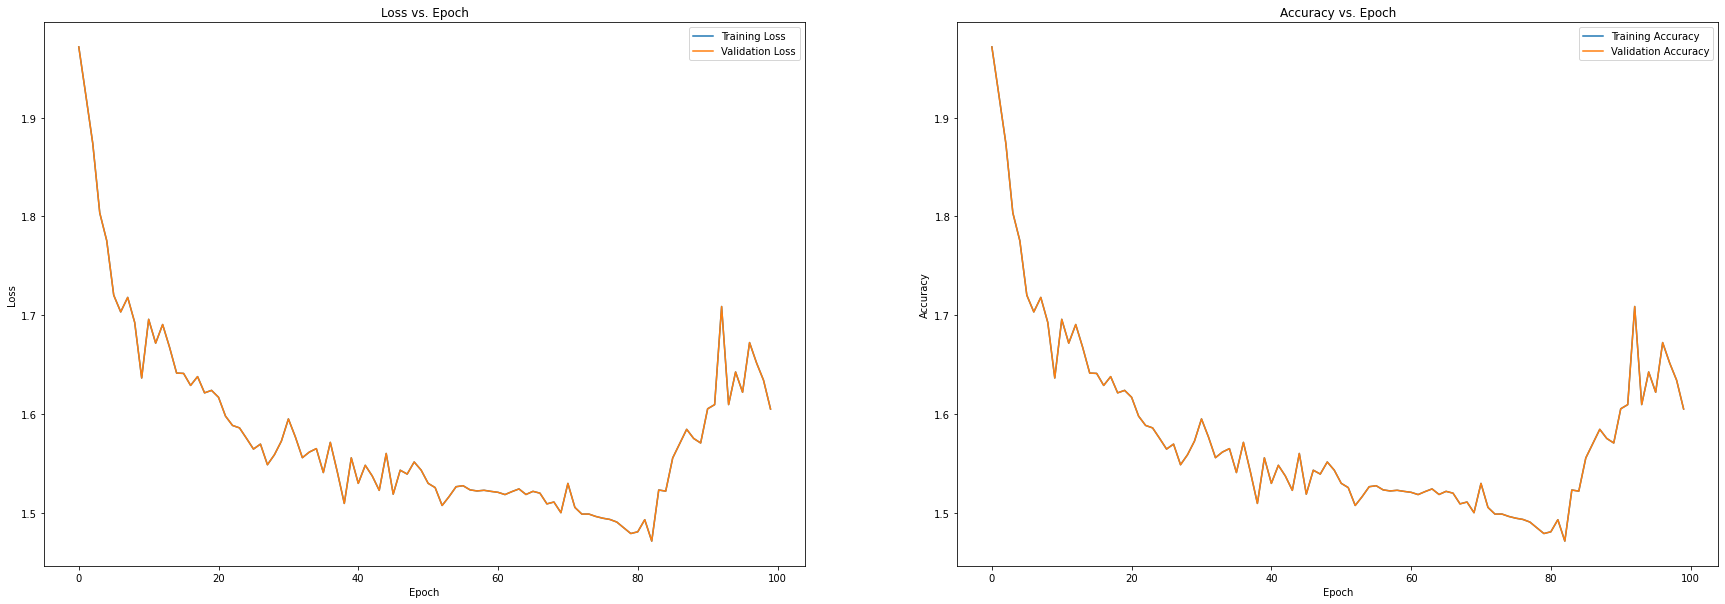

In [28]:
[fig, ax] = plt.subplots(1, 2, figsize=(30, 10))

ax[0].plot(train_losses, label='Training Loss')
ax[0].plot(valid_losses, label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss vs. Epoch')
ax[0].legend()

ax[1].plot(train_accuracies, label='Training Accuracy')
ax[1].plot(valid_accuracies, label='Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy vs. Epoch')
ax[1].legend()


In [54]:
sample = valid_dataloader.dataset[1]
predicted, accuracy = predict(audio_cnn, sample[0])

print(f"Target: {dataset.classes[sample[1]]}, Prediction: {predicted}")


Target: 0, Prediction: 7
